# Линейная алгебра в контексте линейных методов

## Прогнозирование выработки газа на скважинах.

У нас есть набор данных о добыче газа на скважинах. Если открывать новые скважины,  необходимо оценить, сколько денег будет приносить каждая следующая скважина, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа.

Задача — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

%matplotlib inline

Прочитаем исходные данные:

In [4]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## 1. Линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.


Сначала небольшой разведывательный анализ

In [5]:
data.describe()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


array([[<AxesSubplot: title={'center': 'Well'}>,
        <AxesSubplot: title={'center': 'Por'}>,
        <AxesSubplot: title={'center': 'Perm'}>],
       [<AxesSubplot: title={'center': 'AI'}>,
        <AxesSubplot: title={'center': 'Brittle'}>,
        <AxesSubplot: title={'center': 'TOC'}>],
       [<AxesSubplot: title={'center': 'VR'}>,
        <AxesSubplot: title={'center': 'Prod'}>, <AxesSubplot: >]],
      dtype=object)

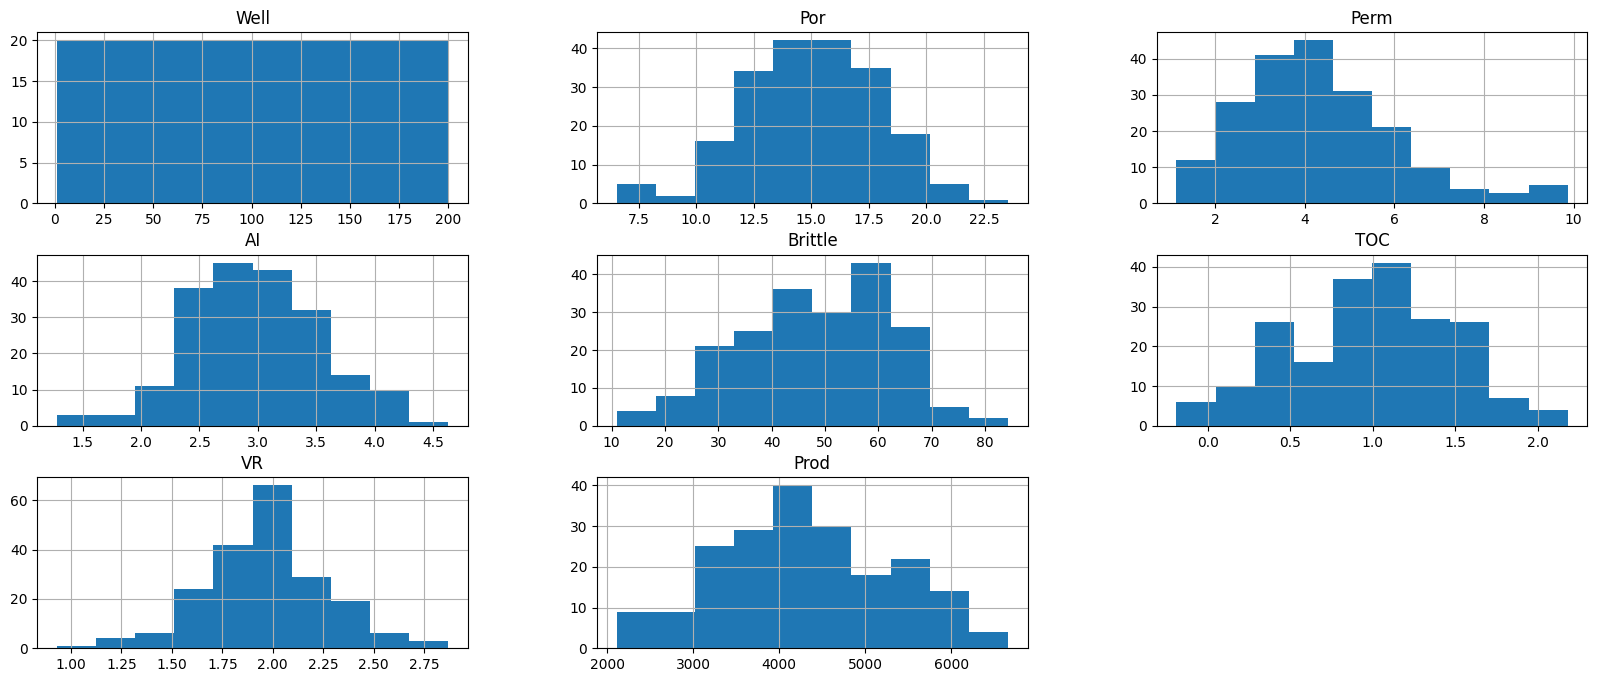

In [6]:
# Построим распределение признаков исходных данных
data.hist(figsize=(20, 8)) # Еще можно использовать pariplot

Предварительно можно сделать вывод, что все коэффициенты имеют близкое к нормальному распределния, хотя и с перекосами в некоторых случаях: к примеру проницаемость скважины (perm) смещена в пользу низких значений, а VR — коэффициент отражения витринита имеет форму вытянутого колокола (т.е. концентрация у середины). У всех показателей среднее и медианное находятся рядом, значительных выбросов также не наблюдается

Построим корреляционную матрицу факторов, включив в неё целевой признак. 

Вычислим ранг и определитель полученной матрицы корреляций и попробуем ответить на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

In [13]:
corr = data.corr()
corr

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


<AxesSubplot: >

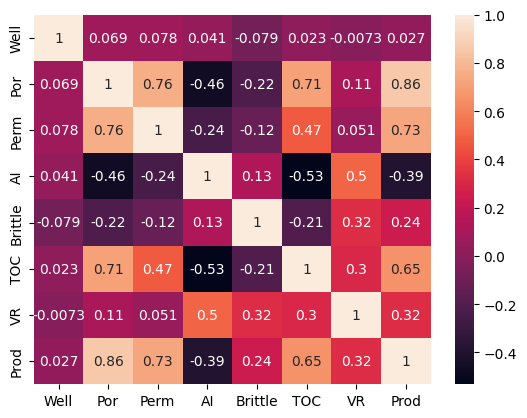

In [12]:
sns.heatmap(corr, annot=True)

Довольно высокая корреляция между целевой переменной Prod и переменными Por и Perm, однако и между этими признаками также высокая корреляция, между ними возможна мультиколлинеарность. Также подозрительным выглядит корреляция 0.71 между Por и Toc

In [15]:
# ранг и определитель
print(np.linalg.matrix_rank(corr)) # ранг
print(np.linalg.det(corr)) # определеитель

8
0.0007299388072652069


Ранг 8 говорит о том, что все признаки значимы, однако близкий к нулю определитель сигнализирует о возможном наличии мультиколлинеарности

Создадим матрицу наблюдений `X` и вектор правильных ответов `y`.
Построим модель линейной регрессии по методу наименьших квадратов. 

In [16]:
#X - матрица наблюдений, y - столбец правильных ответов
X = data.drop('Prod', axis=1)
y = data['Prod']

In [33]:
# проверим размерность
print(X.shape)

(200, 7)


In [20]:
# вычислим OLS-оценку для коэффициентов
w_hat = np.linalg.inv(X.T@X)@X.T@y
print(np.round(w_hat.values,0))

[  -0.  185.  158. -676.   20. -273. 1125.]


Очевидно, что идентификатор скважины неинформативен.

При увеличении показателя Por на 1, целевая переменная увеличится на 185 (т.е. добыча вырастет на 185 млн. кубических футов). Аналогично если AI уменьшить на 1, то это приведет к приросту целевой переменной на 676.

In [29]:
new=np.array([[106.0, 15.32, 3.71, 3.29, 55.99, 1.35, 2.42]])
prediction = new@w_hat # перемножаем новые данные с коэффициентами полученными из регрессии
prediction

array([4631.7085706])

In [28]:
# считаем MAE для нового наблюдения
from sklearn import metrics
print(metrics.mean_absolute_error([4748.315024], prediction))

116.60645339922667


In [43]:
w_hat = np.array(w_hat) # переводим в np для скалярного перемножения

In [45]:
# теперь рассчитаем столбец Y_predicted
y_pred = X@w_hat
y_pred

0      4669.090728
1      3438.866789
2      4524.430981
3      5145.359297
4      3743.849682
          ...     
195    4094.248600
196    5521.141047
197    3279.126178
198    5156.782624
199    5841.191278
Length: 200, dtype: float64

In [47]:
#Рассчитываем MAE
print('MAE score: {:.3f}'.format(metrics.mean_absolute_error(y, y_pred)))
#Рассчитываем MAPE
print('MAPE score: {:.3f}'.format(metrics.mean_absolute_percentage_error(y, y_pred) * 100))
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_pred)))

MAE score: 171.353
MAPE score: 3.983
R2 score: 0.950


Модель ошибается в среднем на 170 млн. кубических футов, т.е. примерно на 4%. Также точность модель более 90% - что отличный результат несмотря на мультиколлинеарность (на результат она повлиять и не должна была, только на интерпретацию коэффициентов)

Настало время анализа построенной модели. Посмотрим на коэффициенты и сравним их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые мы нашли ранее.

В рамках нашей модели признак TOC имеет в корреляционной матрице положительный знак, а в коэффициентах регрессии отрицательный

Полученное противоречие результатов связано с тем, что этот признак косвенно получается как связь других факторов и поэтому приводит к мультиколлинеарности

Исключим из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`. Также исключим факторы, для которых корреляция с целевой переменной меньше `0.05`.

Построим модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. 

5
0.02018067343345253


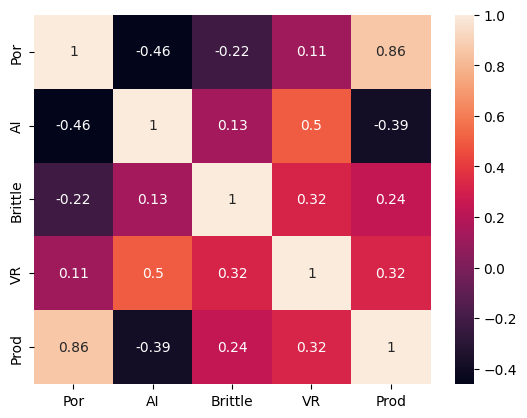

In [74]:
data_dropped = data.drop(['TOC', 'Well', 'Perm'], axis=1)

corr_2 = data_dropped.corr()
sns.heatmap(corr_2, annot=True)

# ранг и определитель
print(np.linalg.matrix_rank(corr_2)) # ранг
print(np.linalg.det(corr_2)) # определеитель

#X - матрица наблюдений, y - столбец правильных ответов
X = data_dropped.drop('Prod', axis=1)
y = data_dropped['Prod']

Исключили следующие факторы:
- 'TOC' - из-за неопределнного знака зависимости
- 'Well' - из-за неинформативности
- 'Perm' - из-за высокой корреляции с другим фактором

In [63]:
# вычислим OLS-оценку для коэффициентов
w_hat = np.linalg.inv(X.T@X)@X.T@y
print(np.round(w_hat.values,0))

[ 235. -486.   22.  598.]


Теперь все знаки оценок совпадают

In [64]:
w_hat = np.array(w_hat) # переводим в np для скалярного перемножения

# теперь рассчитаем столбец Y_predicted
y_pred = X@w_hat
y_pred

0      4668.329234
1      3495.727769
2      4590.896976
3      4885.434033
4      3954.122560
          ...     
195    4090.026651
196    4815.904666
197    3440.958646
198    5150.098914
199    5725.531278
Length: 200, dtype: float64

In [65]:
#Рассчитываем MAE
print('MAE score: {:.3f}'.format(metrics.mean_absolute_error(y, y_pred)))
#Рассчитываем MAPE
print('MAPE score: {:.3f}'.format(metrics.mean_absolute_percentage_error(y, y_pred) * 100))
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_pred)))

MAE score: 216.939
MAPE score: 5.025
R2 score: 0.917


Точность модели немного снизилась, что ожидаемо из-за уменьшения количества факторов. Сама модель все еще не идеальна, ее определитель близок к нулю (хотя и стало лучше), и нет факторов, которые не были бы скоррелированы между собой, но при этом хорошо описывали целевую переменную.

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

In [67]:
from sklearn import linear_model

#Создаём объект класса LinearRegression
lr_lstat = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_lstat.fit(X, y) # метод fit() у объекта LinearRegression реализует ту же самую формулу МНК

print('w0: {}'.format(lr_lstat.intercept_)) #свободный член w0
print('w1: {}'.format(lr_lstat.coef_)) #остальные параметры модели w1, w2, ..., wm

#Предсказываем медианную цену для всех участков из набора данных
y_pred = lr_lstat.predict(X)

w0: -1835.4464606940319
w1: [ 293.03624565 -200.03091206   27.64098209  517.40272597]


In [68]:
#Рассчитываем MAE
print('MAE score: {:.3f}'.format(metrics.mean_absolute_error(y, y_pred)))
#Рассчитываем MAPE
print('MAPE score: {:.3f}'.format(metrics.mean_absolute_percentage_error(y, y_pred) * 100))
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_pred)))

MAE score: 171.431
MAPE score: 4.044
R2 score: 0.945


С помощью библиотеки sklearn удалось повысить точность модели на ограниченном датасете факторов почти до изначальной величины

## 2. Полиномиальная регрессия и регуляризация

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

In [69]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

Стандаризируем признаки затем сгенерируем полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. 

In [75]:
# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
X = scaler.fit_transform(X)
# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)
X.shape

(200, 34)

Получилось 34 фактора из 5 выбранных

In [76]:
# создаём модель линейной регрессии
lr = LinearRegression()
 
# оцениваем качество модели на кросс-валидации, метрика — MAPE
cv_results = cross_validate(lr, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))	

MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.68 %


Отличный результат - средняя ошибка на валидационных фолдах меньше 2.7%, но на тренировочных меньше

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

In [110]:
# Х уже стандартизирован выше и полиномиальные признаки сформированы
# создаём модель линейной регрессии c L1-регуляризацией

params = {'alpha': (np.logspace(-8, 8, 100))} 
lasso = Lasso()
lasso_model = GridSearchCV(lasso, params, scoring='neg_mean_absolute_percentage_error', cv = 5)
lasso_model.fit(X, y)
print(lasso_model.best_params_)
print(-lasso_model.best_score_)

C:\Users\Lyudmila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.676e+05, tolerance: 1.612e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Lyudmila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.429e+05, tolerance: 1.545e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Lyudmila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

{'alpha': 5.336699231206324}
0.022768140319137632


In [107]:
# запускаем модель с выбранным гиперпараметром
lasso = Lasso(alpha=5.3, max_iter=10000)

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(lasso, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

MAPE на тренировочных фолдах: 1.83 %
MAPE на валидационных фолдах: 2.28 %


Генератор делает вывод, что лучшее значение 'alpha': 5.3, где MAPE на валидационной выборке составляет 2.27%, что лучше 2.68 % без регуляризации


Проделаем то же самое с $L_2$-регуляризацией.


In [111]:
# создаём модель линейной регрессии c L2-регуляризацией

params = {'alpha': (np.logspace(-8, 8, 100))} 
ridge = Ridge()
ridge_model = GridSearchCV(ridge, params, scoring='neg_mean_absolute_percentage_error', cv = 5)
ridge_model.fit(X, y)
print(ridge_model.best_params_)
print(-ridge_model.best_score_)

{'alpha': 0.18738174228603868}
0.026723022192169786


In [113]:
# запускаем модель с выбранным гиперпараметром
ridge = Ridge(alpha=0.187, max_iter=10000)

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(ridge, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.67 %


Генератор делает вывод, что лучшее значение 'alpha': 0.187, где MAPE на валидационной выборке составляет 2.67 %, что лучше 2.68 % без регуляризации, но хуже 2.27% L-1 регуляризации


Настало время комбинировать $L_1$ и $L_2$ -регуляризации. Обучим модель `ElasticNet` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

In [115]:
# создаём модель линейной регрессии c L2-регуляризацией

params = {'alpha': (np.logspace(-1, 6, 20)),
          'l1_ratio': (np.logspace(-1, 6, 20))} 
elasticnet = ElasticNet()
elasticnet_model = GridSearchCV(elasticnet, params, scoring='neg_mean_absolute_percentage_error', cv = 5)
elasticnet_model.fit(X, y)
print(elasticnet_model.best_params_)
print(-elasticnet_model.best_score_)

{'alpha': 0.1, 'l1_ratio': 0.5455594781168519}
0.03485617049314962


C:\Users\Lyudmila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1700 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lyudmila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lyudmila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCa

In [116]:
# запускаем модель с выбранным гиперпараметром
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.545)

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(elasticnet, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

MAPE на тренировочных фолдах: 2.53 %
MAPE на валидационных фолдах: 3.49 %


Генератор делает вывод, что лучшее значение 'alpha': 0.1, а 'l1_ratio': 0.545, тогда MAPE на валидационной выборке составляет 3.49 %, что хуже всех ранее приведенных вариантов

In [120]:
# создаётся pd.DataFrame()
final_modeling = pd.DataFrame({
    'model': ['Linear all factors', 'Linear crossed factors', 'Linear skylearn', 'Poly skylearn', 'Poly skylearn+L1', 'Poly skylearn+L2', 'Poly skylearn+ElasticNet'],
    'hyperparameters': [None, None, None, None, 'L1', 'L2', 'ElasticNet'],
    'poly': [False, False, False, True, True, True, True],
    'MAPE_train_score': [3.983, 5.025, 4.044, 1.77, 1.83, 1.77, 2.53],
    'MAPE_valid_score': [None, None, None, 2.68, 2.28, 2.67, 3.49]
})
display(final_modeling)

,model,hyperparameters,poly,MAPE_train_score,MAPE_valid_score
0,Linear all factors,None,False,3.983,NaN
1,Linear crossed factors,None,False,5.025,NaN
2,Linear skylearn,None,False,4.044,NaN
3,Poly skylearn,None,True,1.770,2.68
4,Poly skylearn+L1,L1,True,1.830,2.28
5,Poly skylearn+L2,L2,True,1.770,2.67
6,Poly skylearn+ElasticNet,ElasticNet,True,2.530,3.49


Наилучший результат дает полиномиальная модель из бибилиотеки skylearn с L1-регуляризацией. Несмотря на то, что в первых 3ех моделях не тестировалась валидационная выборка, даже на тренинговой выборке очевидно преимущество 4-ой модели и ниже. 